In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib

# Load the dataset
df = pd.read_csv('Historical_Data_2021_Jan_2024.csv')

# Parse the Date column to extract Year and Month
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Aggregate data on a monthly basis, including the Season feature
monthly_df = df.groupby(['Year', 'Month', 'Medicine', 'Season']).agg({
    'Quantity(Packets)': 'sum'  # Summing up the quantities
}).reset_index()

# Create lagged features
monthly_df['Prev_Month_Quantity'] = monthly_df.groupby('Medicine')['Quantity(Packets)'].shift(1)
monthly_df.dropna(inplace=True)

# One-hot encode the 'Season' feature
monthly_df = pd.get_dummies(monthly_df, columns=['Season'], drop_first=True)

# Define the feature columns and target variable
features = ['Year', 'Month', 'Prev_Month_Quantity'] + [col for col in monthly_df.columns if 'Season' in col]
target = 'Quantity(Packets)'

# Split the data into training and test sets
X = monthly_df[features]
y = monthly_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model
best_rf_model = grid_search.best_estimator_

# Evaluate the model
y_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Save the model and features
joblib.dump(best_rf_model, 'best_rf_model.pkl')
joblib.dump(features, 'feature_columns.pkl')


Mean Squared Error: 879.896270492633


['feature_columns.pkl']

In [23]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
import pickle

# Load the data
data = pd.read_csv("Historical_Data_2021_Jan_2024.csv")

# Feature Engineering
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Prev_Month_Quantity'] = data.groupby('Medicine')['Quantity(Packets)'].shift(1)

# Drop missing values after adding shifted data
data.dropna(inplace=True)

# Create dummy variables for categorical features
medicines_dummies = pd.get_dummies(data['Medicine'], prefix='Medicine')
disease_dummies = pd.get_dummies(data['Disease'], prefix='Disease')
season_dummies = pd.get_dummies(data['Season'], prefix='Season')

# Concatenate the features with the main dataframe
data = pd.concat([data, medicines_dummies, disease_dummies, season_dummies], axis=1)

# Define feature columns
feature_columns = ['Year', 'Month', 'Prev_Month_Quantity'] + list(medicines_dummies.columns) + list(disease_dummies.columns) + list(season_dummies.columns)

X = data[feature_columns]
y = data['Quantity(Packets)']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Set up GridSearch to find the best parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters from GridSearch
best_xgb = grid_search.best_estimator_

# Train final model with the best parameters
best_xgb.fit(X_train, y_train)

# Save the model
with open("best_xgb_model.pkl", "wb") as f:
    pickle.dump(best_xgb, f)

# Save feature columns
with open("feature_columns.pkl", "wb") as f:
    pickle.dump(feature_columns, f)

print("XGBoost model training completed and saved.")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
XGBoost model training completed and saved.


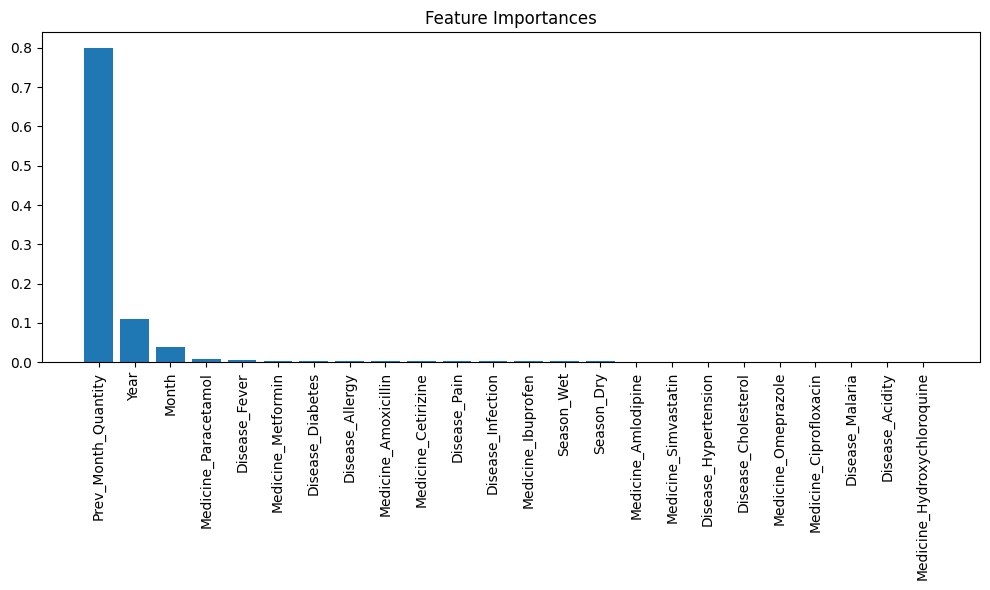

In [13]:
import matplotlib.pyplot as plt

# Plot feature importance
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [feature_columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()
